# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [3]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely

from sqlalchemy import *
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

In [90]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = "/Users/chenruijia/Desktop/AnalyticsTools/NYC-Rental-Analysis/data/drive-download-20231124T164450Z-001/nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "IxFjBjShI6cenJ0NOVZ1rnj0W"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "group14project"
DB_USER = "chenruijia"
DB_URL = f"postgres+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [91]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In [4]:
def download_nyc_geojson_data(url, force=False):
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = DATA_DIR / url_path
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        
        ...
        
        with open(filename, "w") as f:
            json.dump(..., f)
        print(f"Done downloading {url}.")

    else:
        print(f"Reading from {filename}...")

    return filename

In [5]:
import geopandas as gpd
import pyproj
from functools import partial
from shapely.ops import transform
from shapely.geometry import Polygon

# Assuming the primary .shp file is 'nyc_zipcodes.shp' and it's in the same directory with other related files
shapefile_path = 'data/drive-download-20231124T164450Z-001/nyc_zipcodes.shp'


def load_and_clean_zipcodes(shapefile_path):
    # Reading the shapefile
    geodf_zipcode = gpd.read_file(shapefile_path)

    # Filter out non-Polygon geometries
    geodf_zipcode = geodf_zipcode[geodf_zipcode['geometry'].apply(lambda geom: isinstance(geom, Polygon))]

    # Filter by ZIPCODE pattern (New York City zip codes starting with '1')
    geodf_zipcode = geodf_zipcode[geodf_zipcode['ZIPCODE'].astype(str).str.match(r'^1\d{4}$')]
    
    # Defining the coordinate reference systems
    current_srid = 'EPSG:2263'  # NAD83 / New York Long Island (ftUS)
    desired_srid = 'EPSG:4326'  # WGS 84

    # Updating to use pyproj.Transformer
    transformer = pyproj.Transformer.from_crs(current_srid, desired_srid, always_xy=True)

    # Applying the transformation
    geodf_zipcode['geometry'] = geodf_zipcode['geometry'].apply(lambda geom: transform(transformer.transform, geom))

    return geodf_zipcode


 


In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
def download_and_clean_311_data():
    def fetch_data(offset, limit):
        api_endpoint = f"{base_api_endpoint}?{soql_query}&$select={columns}&$limit={limit}&$offset={offset}"
        response = requests.get(api_endpoint, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            return []
    base_api_endpoint = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
    columns = 'unique_key,created_date,closed_date,complaint_type,incident_zip,latitude,longitude'
    start_date = '2015-01-01T00:00:00'
    end_date = '2023-09-30T23:59:59'
    headers = {'X-App-Token': NYC_DATA_APP_TOKEN}
    soql_query = f"$where=created_date between '{start_date}' and '{end_date}'"
    limit = 200000
    all_data = []
    offset = 0
    more_data = True

    while more_data:
        with ThreadPoolExecutor(max_workers=10) as executor:

            futures = [executor.submit(fetch_data, off, limit) for off in range(offset, offset + 10 * limit, limit)]
    
            for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching Data"):
                data = future.result()
                if data:
                    all_data.extend(data)
                    print(f"Retrieved records up to offset {offset + limit}...")
                else:
                    more_data = False

            offset += 10 * limit
    
    nyc_311_data = pd.DataFrame(all_data)
    nyc_311_data['created_date'] = pd.to_datetime(nyc_311_data['created_date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
    nyc_311_data['closed_date'] = pd.to_datetime(nyc_311_data['closed_date'], format='%Y-%m-%dT%H:%M:%S.%f',errors='coerce')
    nyc_311_data = nyc_311_data.dropna(subset=['created_date', 'closed_date'])

    return nyc_311_data
 

In [ ]:
nyc_311_data = download_and_clean_311_data()

In [35]:
def download_and_clean_tree_data():
    base_api_endpoint = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json' 
    columns = 'tree_id,latitude,longitude,status,health,spc_common,zipcode'
    
    headers = {
        'X-App-Token': NYC_DATA_APP_TOKEN
    }
    
    limit = 50000   
    offset = 0
    all_data = []

    while True:
        api_endpoint = f"{base_api_endpoint}?$select={columns}&$limit={limit}&$offset={offset}"
        response = requests.get(api_endpoint, headers=headers)
        
        if response.status_code == 200:
            page_data = response.json()
    
            if not page_data:
                break
            all_data.extend(page_data)
            offset += limit
            print(f"Retrieved {offset} records so far...")
        else:
            print("Failed to retrieve data:", response.status_code)
            break
    
    geodf_tree_data = pd.DataFrame(all_data)
    geodf_tree_data.dropna(subset=['tree_id', 'latitude', 'longitude', 'status', 'health', 'spc_common', 'zipcode'], inplace=True)
    return geodf_tree_data

In [34]:
def load_and_clean_zillow_data():
    zillow_rent_data = pd.read_csv('data/drive-download-20231124T164450Z-001/zillow_rent_data.csv')

    
    nyc_zip_codes = zillow_rent_data[zillow_rent_data['RegionName'].astype(str).str.match(r'^1\d{4}$')]

    columns_to_delete = ["RegionID", "SizeRank", "RegionType", "StateName", "State", "City", "Metro", "CountyName"]
    df = nyc_zip_codes.drop(columns=columns_to_delete)

    df_long = df.melt(id_vars=["RegionName"], 
                    var_name="Date", 
                    value_name="RentPrice")


    df_long['Date'] = pd.to_datetime(df_long['Date'])

    df_long = df_long.sort_values(by=['RegionName', 'Date'])

    
    df_long['RentPrice'] = df_long.groupby('RegionName')['RentPrice'].ffill()
    df_long['RentPrice'] = df_long.groupby('RegionName')['RentPrice'].bfill()
    df_long['RentPrice'] = df_long.groupby('RegionName')['RentPrice'].ffill().bfill().interpolate(method='linear')

    zillow_data = pd.DataFrame(df_long)
    return zillow_data

 

In [31]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )


In [ ]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [ ]:
# Show basic info about each dataframe
geodf_zipcode_data.info()


In [ ]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

In [ ]:
geodf_311_data.info()

In [ ]:
geodf_311_data.head()

In [ ]:
geodf_tree_data.info()

In [ ]:
geodf_tree_data.head()

,tree_id,latitude,longitude,status,health,spc_common,zipcode
0,180683,40.72309177,-73.84421522,Alive,Fair,red maple,11375
1,200540,40.79411067,-73.81867946,Alive,Fair,pin oak,11357
2,204026,40.71758074,-73.9366077,Alive,Good,honeylocust,11211
3,204337,40.71353749,-73.93445616,Alive,Good,honeylocust,11211
4,189565,40.66677776,-73.97597938,Alive,Good,American linden,11215


In [ ]:
df_zillow_data.info()

In [ ]:
df_zillow_data.head()

,RegionName,Date,RentPrice
311,10001,2015-01-31,3807.657462
867,10001,2015-02-28,3851.098684
1423,10001,2015-03-31,3844.716691
1979,10001,2015-04-30,3906.689196
2535,10001,2015-05-31,3960.689870


## Part 2: Storing Data

In [ ]:
def setup_new_postgis_database(username, db_name):
    raise NotImplementedError()

In [ ]:
setup_new_postgis_database(DB_USER, DB_NAME)

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

#### Option 2: SQLAlchemy

In [ ]:
!createdb group14

In [ ]:
!psql --dbname group14project -c 'CREATE EXTENSION postgis;'

In [6]:
!pip install psycopg2
!pip install sqlalchemy pandas geoalchemy2


In [7]:
from geoalchemy2 import Geometry

In [4]:
Base = declarative_base()
engine = create_engine('postgresql://chenruijia:@localhost/group14project')

/var/folders/dn/w_0bwtz955bbs9x6hcsffb540000gn/T/ipykernel_30733/1203867692.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [8]:

# create Geo Zip Code table
class GeoZipCode(Base):
    __tablename__ = 'geo_zip_codes'
    id = Column(Integer, primary_key=True, autoincrement=True, nullable=False)
    ZIPCODE = Column(Integer, primary_key=True)
    BLDGZIP = Column(String)
    PO_NAME = Column(String)
    POPULATION = Column(Float)
    AREA = Column(Float)
    STATE = Column(String)
    COUNTY = Column(String)
    ST_FIPS = Column(Integer)
    CTY_FIPS = Column(Integer)
    URL = Column(String)
    SHAPE_AREA = Column(Float)
    SHAPE_LEN = Column(Float)
    geometry = Column(Geometry(geometry_type='POLYGON'))

# create Tree Census table
class TreeCensus(Base):
    __tablename__ = 'tree_censuses'
    id = Column(Integer, primary_key=True)
    tree_id = Column(Integer, primary_key=True)
    latitude = Column(Float)
    longitude = Column(Float)
    status = Column(String)
    health = Column(String)
    spc_common = Column(String)
    zipcode = Column(Integer)

# create Zillow Rent table
class ZillowRent(Base):
    __tablename__ = 'zillow_rents'
    id = Column(Integer, primary_key=True)
    RegionName = Column(String, primary_key=True)
    Date = Column(Date)
    RentPrice = Column(Float)
    
# create NYC 311 table
class NYC311(Base):
    __tablename__ = 'nyc_311_services'
    id = Column(BigInteger, primary_key=True)
    unique_key = Column(VARCHAR(8), unique=True, primary_key=True)
    created_date = Column(DateTime(timezone=True))
    closed_date = Column(DateTime(timezone=True))
    complaint_type = Column(String)
    incident_zip = Column(VARCHAR(5))
    latitude = Column(Float)
    longitude = Column(Float)

In [9]:
Base.metadata.create_all(engine)

In [10]:
Base.metadata.tables

FacadeDict({'geo_zip_codes': Table('geo_zip_codes', MetaData(), Column('id', Integer(), table=<geo_zip_codes>, primary_key=True, nullable=False), Column('ZIPCODE', Integer(), table=<geo_zip_codes>, primary_key=True, nullable=False), Column('BLDGZIP', String(), table=<geo_zip_codes>), Column('PO_NAME', String(), table=<geo_zip_codes>), Column('POPULATION', Float(), table=<geo_zip_codes>), Column('AREA', Float(), table=<geo_zip_codes>), Column('STATE', String(), table=<geo_zip_codes>), Column('COUNTY', String(), table=<geo_zip_codes>), Column('ST_FIPS', Integer(), table=<geo_zip_codes>), Column('CTY_FIPS', Integer(), table=<geo_zip_codes>), Column('URL', String(), table=<geo_zip_codes>), Column('SHAPE_AREA', Float(), table=<geo_zip_codes>), Column('SHAPE_LEN', Float(), table=<geo_zip_codes>), Column('geometry', Geometry(geometry_type='POLYGON', from_text='ST_GeomFromEWKT', name='geometry'), table=<geo_zip_codes>), schema=None), 'tree_censuses': Table('tree_censuses', MetaData(), Column('

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### Option 2: SQLAlchemy

In [11]:
Session = sessionmaker(bind=engine)
session = Session()

In [80]:
# Insert data into the geo_zip_codes table

from geoalchemy2 import WKTElement
import shapely.wkt

geodf_zipcode = geodf_zipcode[[col for col in geodf_zipcode.columns if col != 'id']]
zipcode_data_list = geodf_zipcode.to_dict(orient='records')

for data in zipcode_data_list:
    geometry_data = data.pop('geometry')

    # Convert Shapely geometry to WKT
    wkt_representation = shapely.wkt.dumps(geometry_data)
    
    # Create a GeoAlchemy WKTElement from the WKT representation
    wkt_element = WKTElement(wkt_representation, srid=4326)
    
    # Add the geometry data back to the dictionary
    data['geometry'] = wkt_element
    
    zipcode = GeoZipCode(**data)
    session.add(zipcode)
session.commit()

In [79]:
session.rollback()

In [ ]:
# Query the geo_zip_codes table

zip_code_rows = session.query(GeoZipCode).all()
print("Number of rows:", len(zip_code_rows))
for result in zip_code_rows:
    print(result.__dict__)

In [ ]:
# Insert data into the tree_censuses table

geodf_tree_data['id'] = range(len(geodf_tree_data))
geodf_tree_data = geodf_tree_data[['id'] + [col for col in geodf_tree_data.columns if col != 'id']]
tree_data_list = geodf_tree_data.to_dict(orient='records')

for data in tree_data_list:
    tree_census = TreeCensus(**data)
    session.add(tree_census)

session.commit()

In [ ]:
# Query the tree_censuses table
tree_census_rows = session.query(TreeCensus).all()
print("Number of rows:", len(tree_census_rows))
for result in tree_census_rows:
    print(result.__dict__)

In [ ]:
# Insert data into the zillow rent table

zillow_rent_data = df_long
zillow_rent_data['id'] = range(len(zillow_rent_data))
zillow_rent_data = zillow_rent_data[['id'] + [col for col in zillow_rent_data.columns if col != 'id']]
zillow_rent_data_list = zillow_rent_data.to_dict(orient='records')

for data in zillow_rent_data_list:
    zillow_rent = ZillowRent(**data)
    session.add(zillow_rent)

session.commit()

In [ ]:
# Query the zillow_rents table

zillow_rent_rows = session.query(ZillowRent).all()
print("Number of rows:", len(zillow_rent_rows))
for result in zillow_rent_rows:
    print(result.__dict__)

In [ ]:
# Insert data into the nyc_311_services table

chunk_size = 10000
# Iterate over the DataFrame in chunks
for start_idx in range(0, len(nyc_311_data), chunk_size):
    end_idx = start_idx + chunk_size
    chunk_data = nyc_311_data.iloc[start_idx:end_idx]

    for index, row in chunk_data.iterrows():
        nyc311 = NYC311(
            id = row['id'],
            unique_key=row['unique_key'],
            created_date=row['created_date'],
            closed_date=row['closed_date'],
            complaint_type=row['complaint_type'],
            incident_zip=row['incident_zip'],
            latitude=row['latitude'],
            longitude=row['longitude']
        )
        session.add(nyc311)

    session.commit()

In [ ]:
# Query the tree_censuses table

tree_census_rows = session.query(TreeCensus).all()
print("Number of rows:", len(tree_census_rows))
for result in tree_census_rows:
    print(result)

## Part 3: Understanding the Data

### Query 1

In [95]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

In [96]:
QUERY_1_FILENAME = QUERY_DIR / "query_1.sql"

QUERY_1 = """
    SELECT incident_zip, COUNT(*) AS num_complaints
    FROM nyc_311_services
    WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
    GROUP BY incident_zip
    ORDER BY num_complaints DESC;
"""

In [97]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [ ]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

In [ ]:
import os
QUERY_2_FILENAME = os.path.join(QUERY_DIR, "most_greenery.sql")

QUERY_2 = """
    SELECT zipcode, COUNT(*) as total_trees
    FROM tree_censuses
    GROUP BY zipcode
    ORDER BY total_trees DESC
    LIMIT 10;
"""

In [ ]:
import sqlalchemy as db
from sqlalchemy import create_engine, text
sql_query = text(QUERY_2)
with engine.connect() as conn:
    result = conn.execute(sql_query)
    rows = result.fetchall()   
    if not rows:
        print("No data found.")
    else:
        print("Top 10 Zip Codes with Most Trees:")
        for row in rows:
            if len(row) != 2:
                print(f"Unexpected row format: {row}")
                continue  
            zipcode, total_trees = row
            print(f"Zip Code: {zipcode}, Total Trees: {total_trees}")

In [ ]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

In [ ]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

In [ ]:
QUERY_3_FILENAME = QUERY_DIR / "rent_for_most_trees.sql"

QUERY_3 = """
     SELECT "RentPrice"
     FROM zillow_rents
     WHERE "RegionName" = :zipcode AND "Date" = '2023-08-31'
"""

sql_query = """
    SELECT zipcode, COUNT(*) as total_trees
    FROM tree_censuses
    GROUP BY zipcode
    ORDER BY total_trees DESC
    LIMIT 10;
"""

QUERY_3_text = text(QUERY_3)
sql_query_text = text(sql_query)

In [ ]:
with engine.connect() as  connection:
    tree_result = connection.execute(sql_query_text)
    print("Top 10 Zip Codes with Most Trees and Their Rent for August 31, 2023:")

    for row in tree_result:
        zipcode, total_trees = row[0], row[1]

        rent_result = connection.execute(QUERY_3_text, {'zipcode': str(zipcode)})
        rent_row = rent_result.fetchone()
        formatted_rent_price = "{:,.2f}".format(rent_row[0])

        print(f"Zip Code: {zipcode}, Rent Price on 2023-08-31: ${formatted_rent_price}")

In [ ]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

In [100]:
QUERY_4_FILENAME = QUERY_DIR / "query_4.sql"

QUERY_4 = """
    (
    SELECT 
        z."RegionName" AS zipcode, 
        to_char(AVG(z."RentPrice"), 'FM9999,999.00') AS average_rent, 
        COALESCE((
            SELECT COUNT(*)
            FROM tree_censuses tc
            WHERE tc.zipcode::text = z."RegionName"
        ), 0) AS tree_count, 
        COALESCE((
            SELECT COUNT(*)
            FROM nyc_311_services nyc
            WHERE nyc.incident_zip = z."RegionName" 
            AND to_char(nyc.created_date, 'YYYY-MM') = '2023-01'
        ), 0) AS complaint_count
    FROM 
        zillow_rents z
    WHERE 
        to_char(z."Date", 'YYYY-MM') = '2023-01'
    GROUP BY 
        z."RegionName"
    ORDER BY 
        AVG(z."RentPrice")
    LIMIT 5
)
UNION ALL
(
    SELECT 
        z."RegionName" AS zipcode, 
        to_char(AVG(z."RentPrice"), 'FM9999,999.00') AS average_rent, 
        COALESCE((
            SELECT COUNT(*)
            FROM tree_censuses tc
            WHERE tc.zipcode::text = z."RegionName"
        ), 0) AS tree_count, 
        COALESCE((
            SELECT COUNT(*)
            FROM nyc_311_services nyc
            WHERE nyc.incident_zip = z."RegionName" 
            AND to_char(nyc.created_date, 'YYYY-MM') = '2023-01'
        ), 0) AS complaint_count
    FROM 
        zillow_rents z
    WHERE 
        to_char(z."Date", 'YYYY-MM') = '2023-01'
    GROUP BY 
        z."RegionName"
    ORDER BY 
        AVG(z."RentPrice") DESC
    LIMIT 5
)
ORDER BY 
    average_rent DESC;
    
"""

In [101]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

In [ ]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

In [ ]:
QUERY_5_FILENAME = QUERY_DIR / "most_greenery_using_zipcode.sql"
QUERY_5 ="""
    SELECT tc.zipcode, COUNT(DISTINCT tc.id) as total_trees
    FROM tree_censuses tc
    JOIN geo_zip_codes gzc
    ON ST_Within(ST_SetSRID(ST_Point(tc.longitude, tc.latitude), 4326), gzc.geometry)
    GROUP BY tc.zipcode
    ORDER BY total_trees DESC
    LIMIT 10;
"""

QUERY_5_text = text(QUERY_5)


In [ ]:
with engine.connect() as connection:
    result = connection.execute(QUERY_5_text)
    print("Top 10 Zip Codes with Most Trees:")
    for row in result:
        zipcode, total_trees = row[0], row[1]
        print(f"Zip Code: {zipcode}, Total Trees: {total_trees}")

In [ ]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

In [ ]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

In [ ]:
from sqlalchemy import func

latitude = 40.80737875669467
longitude = -73.96253174434912
radius_in_miles = 0.5
radius_in_meters = radius_in_miles * 1609.34   

center_point = func.ST_SetSRID(func.ST_MakePoint(longitude, latitude), 4326)

sql_query = f"""
    SELECT *
    FROM tree_censuses tc
    WHERE ST_DWithin(
        ST_SetSRID(ST_MakePoint(tc.longitude, tc.latitude), 4326),
        ST_SetSRID(ST_MakePoint({longitude}, {latitude}), 4326),
        {radius_in_meters}
    )
"""

sql_output = "ID, Species, Health, Status, Coordinates\n"
for tree in trees_within_radius:
    tree_details = f"{tree.id}, {tree.spc_common}, {tree.health}, {tree.status}, {tree.latitude}, {tree.longitude}\n"
    sql_output += tree_details
print(sql_output)

# Save the SQL query to a .sql file
file_path = ' immediate area.sql'  # Replace this with your desired file path
with open(file_path, 'w') as file:
    file.write(sql_query)

## Part 4: Visualizing the Data

### Visualization 1

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_visual_1(dataframe):
    plt.figure(figsize=(15, 10))
    
 
    barplot = sns.barplot(x='complaint_type', y='num_complaints', data=dataframe, palette='viridis')

   
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

    
    plt.title("Number of Complaints per Complaint Type", fontsize=18)
    plt.xlabel("Complaint Type", fontsize=14)
    plt.ylabel("Number of Complaints", fontsize=14)

  
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)


    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.set_style("whitegrid")

    plt.tight_layout()
    plt.show()


In [55]:
def get_data_for_visual_1():
    
    QUERY_1 = text("""
            SELECT complaint_type, COUNT(*) AS num_complaints
            FROM nyc_311_services
            WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
            GROUP BY complaint_type
            ORDER BY num_complaints DESC
            LIMIT 3;
        """)
    with engine.connect() as conn:
        result = conn.execute(QUERY_1)
        dataframe = pd.DataFrame(result.fetchall(), columns=result.keys())
    
    return dataframe


/Users/chenruijia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenruijia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenruijia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


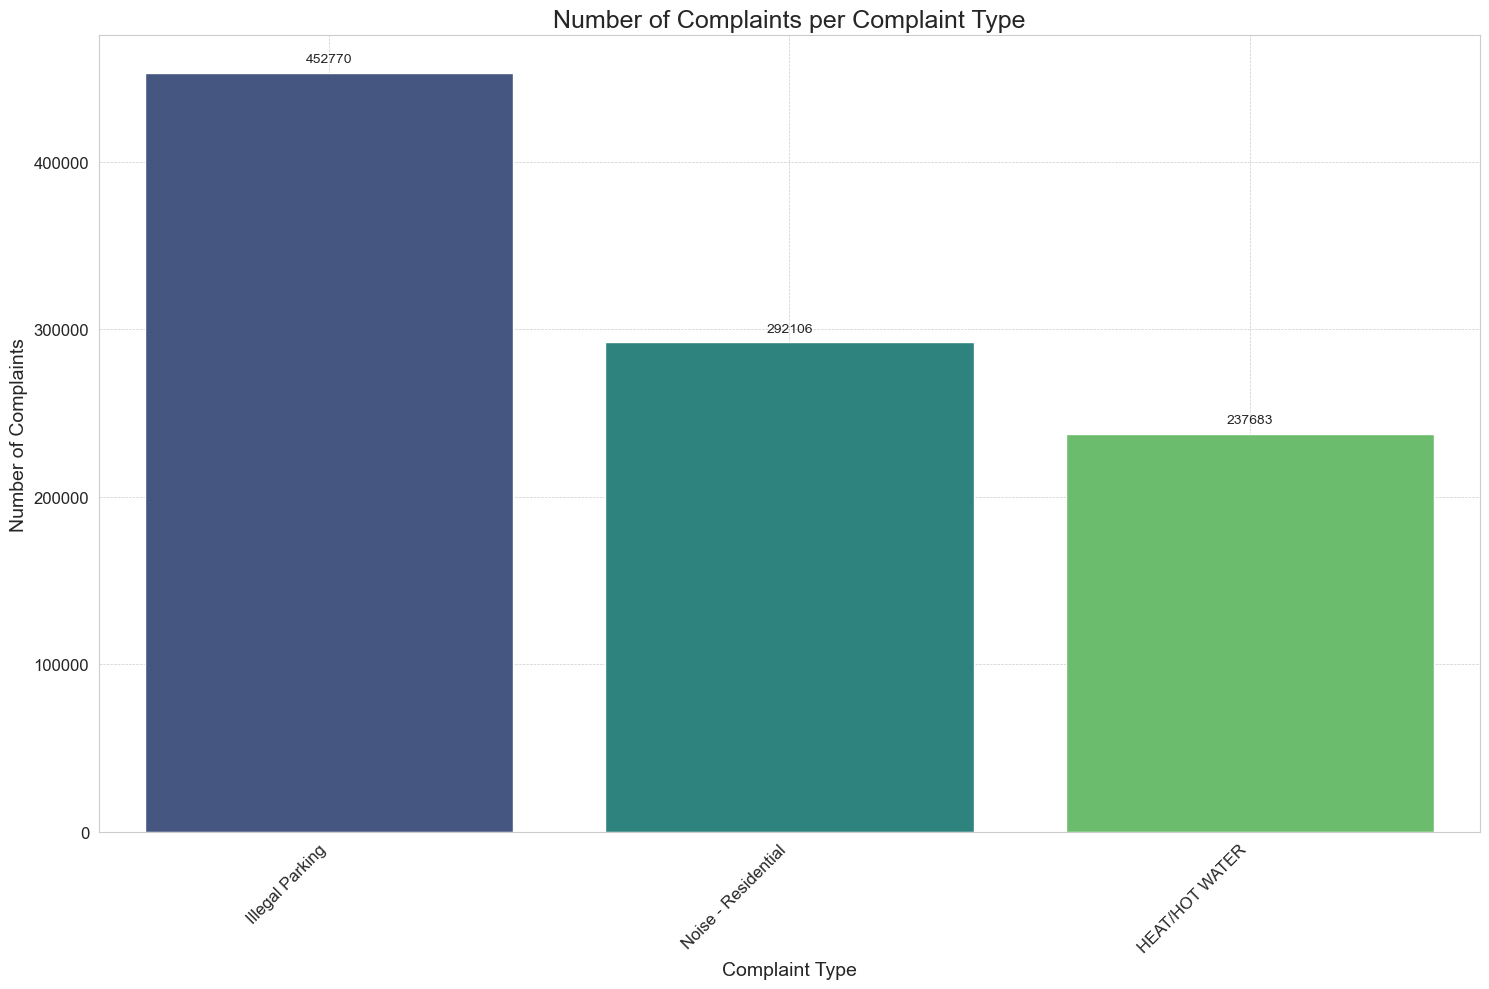

In [102]:
data_for_visualization = get_data_for_visual_1()
plot_visual_1(data_for_visualization)

### Visualization 2

In [59]:

def plot_visual_2(dataframe):
    plt.figure(figsize=(20, 10))
    
    barplot = sns.barplot(x='complaint_type', y='num_complaints', data=dataframe, palette='viridis')

    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

    plt.title("Top 10 Complaints in Zip Code 10027", fontsize=18)
    plt.xlabel("Complaint Type", fontsize=14)
    plt.ylabel("Number of Complaints", fontsize=14)

    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    sns.set_style("whitegrid")

    plt.tight_layout()
    plt.show()




In [60]:

def get_data_for_visual_2():
    QUERY = text("""
        SELECT complaint_type, COUNT(*) AS num_complaints
        FROM nyc_311_services
        WHERE created_date >= '2018-10-01' AND created_date <= '2023-09-30'
        AND incident_zip = '10027'
        GROUP BY complaint_type
        ORDER BY num_complaints DESC
        LIMIT 10;
    """)
    with engine.connect() as conn:
        result = conn.execute(QUERY)
        dataframe = pd.DataFrame(result.fetchall(), columns=result.keys())
    
    return dataframe



/Users/chenruijia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenruijia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenruijia/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


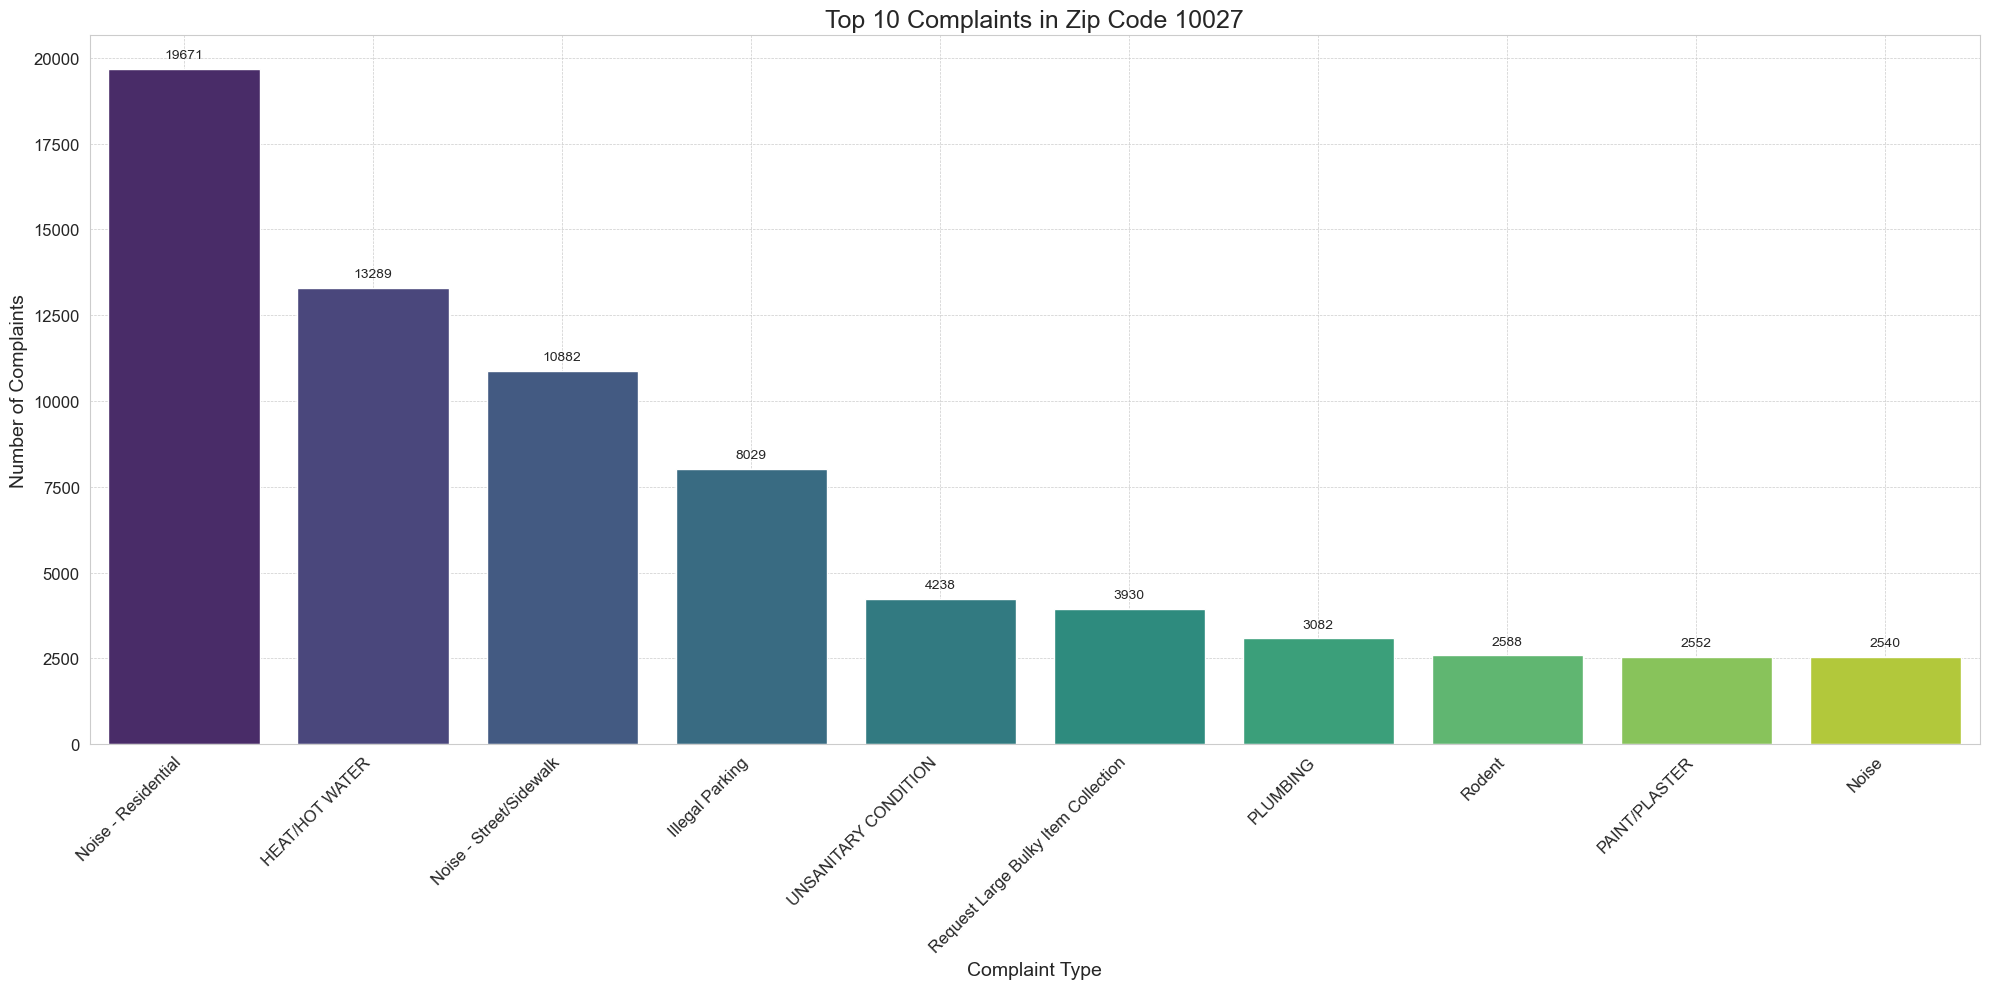

In [61]:
# Get data and plot
data_for_visualization = get_data_for_visual_2()
plot_visual_2(data_for_visualization)

### Visualization 3

In [ ]:
import matplotlib.pyplot as plt
def plot_visual_3(dataframe):
    figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

    ax1.scatter(dataframe['avg_rent'], dataframe['total_trees'])
    ax1.set_title('Average Rent vs Number of Trees by Zip Code')
    ax1.set_xlabel('Average Rent')
    ax1.set_ylabel('Number of Trees')

    ax2.scatter(dataframe['avg_rent'], dataframe['total_complaints'])
    ax2.set_title('Average Rent vs Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')
    ax2.set_ylim(0, 2000)   

    plt.tight_layout()  

In [ ]:
from sqlalchemy import create_engine, text
def get_data_for_visual_3():
    with engine.connect() as connection:
    
        tree_sql_query = text("""
            SELECT zipcode, COUNT(id) AS total_trees
            FROM tree_censuses
            GROUP BY zipcode
        """)
        tree_result = connection.execute(tree_sql_query)
        df_trees = pd.DataFrame(tree_result.fetchall(), columns=['zipcode', 'total_trees'])
        df_trees['zipcode'] = df_trees['zipcode'].astype(str)  # Convert to string

        complaint_sql_query = text("""
            SELECT incident_zip, COUNT(unique_key) AS total_complaints
            FROM nyc_311_services
            GROUP BY incident_zip
        """)
        complaint_result = connection.execute(complaint_sql_query)
        df_complaints = pd.DataFrame(complaint_result.fetchall(), columns=['incident_zip', 'total_complaints'])
        df_complaints['incident_zip'] = df_complaints['incident_zip'].fillna('Unknown')
        df_complaints['incident_zip'] = df_complaints['incident_zip'].astype(str).str.split('.').str[0]
 
        rent_sql_query = text("""
            SELECT "RegionName", AVG("RentPrice") AS avg_rent
            FROM zillow_rents
            WHERE "Date" >= '2015-01-01' AND "Date" <= '2023-09-30'
            GROUP BY "RegionName"
        """)
        rent_result = connection.execute(rent_sql_query)
        df_rent = pd.DataFrame(rent_result.fetchall(), columns=['RegionName', 'avg_rent'])
        df_rent['RegionName'] = df_rent['RegionName'].astype(str)  

        df_merged = df_rent.merge(df_trees, left_on='RegionName', right_on='zipcode', how='outer')
        df_merged = df_merged.merge(df_complaints, left_on='RegionName', right_on='incident_zip', how='outer')

    return df_merged

df_for_visualization = get_data_for_visual_3()
pd.set_option('display.max_rows', None)

In [ ]:
some_dataframe = get_data_for_visual_3()
plot_visual_3(some_dataframe)

### Visualization 4

In [ ]:
def plot_visual_4(dataframe):
    max_rent = dataframe['avg_rent'].max()
    rent_bins = np.arange(0, 10000, 1000)
    rent_labels = [f"${int(b)}-${int(b+1000)}" for b in rent_bins[:-1]]

    dataframe['RentBin'] = pd.cut(dataframe['avg_rent'], bins=rent_bins, labels=rent_labels, include_lowest=True)

    figure, axes = plt.subplots(figsize=(20, 10))
    dataframe.boxplot(column='total_complaints', by='RentBin', ax=axes)
    
    axes.set_title('311 Complaints vs Average Rent in September 2023')
    axes.set_xlabel('Average Rent (in $1000 bins)')
    axes.set_ylabel('Number of 311 Complaints')
    plt.suptitle('')   
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd

def get_data_for_visual_4():
    with engine.connect() as connection:
        rent_sql_query = text("""
            SELECT "RegionName", AVG("RentPrice") AS avg_rent
            FROM zillow_rents
            WHERE "Date" >= '2022-10-01' AND "Date" <= '2023-09-30'
            GROUP BY "RegionName"
        """)
        rent_result = connection.execute(rent_sql_query)
        df_rent = pd.DataFrame(rent_result.fetchall(), columns=['RegionName', 'avg_rent'])
        df_rent['RegionName'] = df_rent['RegionName'].astype(str)

        complaint_sql_query = text("""
            SELECT incident_zip, COUNT(unique_key) AS total_complaints
            FROM nyc_311_services
            WHERE created_date >= '2022-10-01' AND created_date <= '2023-09-30'
            GROUP BY incident_zip
        """)
        complaint_result = connection.execute(complaint_sql_query)
        df_complaints = pd.DataFrame(complaint_result.fetchall(), columns=['incident_zip', 'total_complaints'])
        df_complaints['incident_zip'] = df_complaints['incident_zip'].fillna('Unknown')
        df_complaints['incident_zip'] = df_complaints['incident_zip'].astype(str).str.split('.').str[0]

        df_merged = df_rent.merge(df_complaints, left_on='RegionName', right_on='incident_zip', how='outer')

    return df_merged

df_for_visualization = get_data_for_visual_4()

In [ ]:
df_for_visualization = get_data_for_visual_4()
plot_visual_4(df_for_visualization)

### Visualization 5

In [62]:
def plot_visual_5(gdf):
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, markersize=5, color='blue', label='Incidents')
    
    ax.set_title('Geospatial Plot of 311 Incidents')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()


In [63]:
from sqlalchemy import text
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

def get_data_for_visual_5(center_lat, center_long, radius_degree):
    QUERY = text(f"""
        SELECT latitude, longitude
        FROM nyc_311_services
        WHERE created_date >= '2023-01-01' AND created_date <= '2023-09-30'
        AND (latitude BETWEEN {center_lat - radius_degree} AND {center_lat + radius_degree})
        AND (longitude BETWEEN {center_long - radius_degree} AND {center_long + radius_degree});
    """)
    with engine.connect() as conn:
        result = conn.execute(QUERY)
        dataframe = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    gdf = gpd.GeoDataFrame(
        dataframe, 
        geometry=[Point(xy) for xy in zip(dataframe.longitude, dataframe.latitude)],
        crs="EPSG:4326"
    )
    return gdf


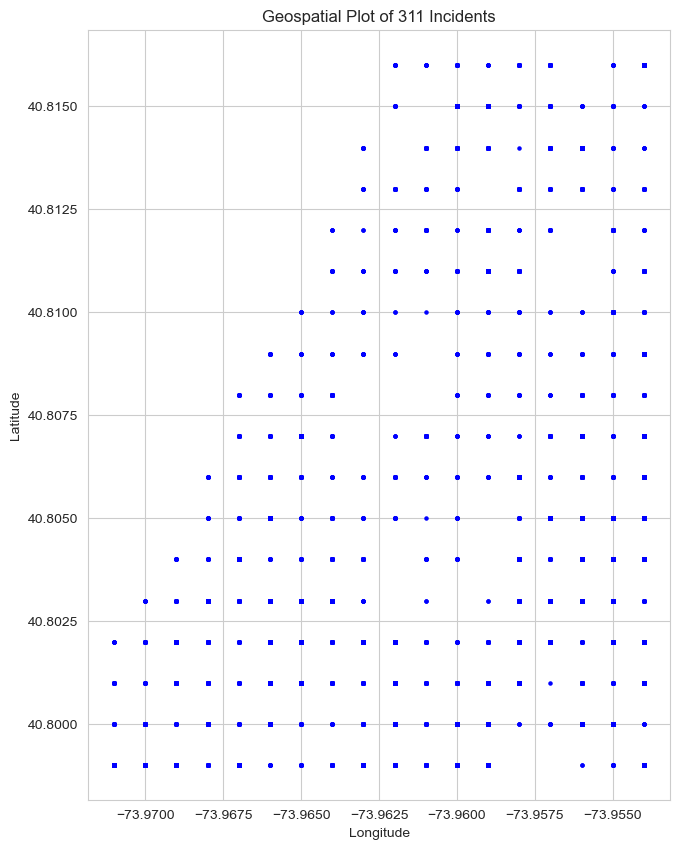

In [64]:
center_lat = 40.80737875669467
center_long = -73.96253174434912

# Calculate the radius in degrees
radius_km = 1
radius_degree = radius_km / 111

data_for_visualization = get_data_for_visual_5(center_lat, center_long, radius_degree)
plot_visual_5(data_for_visualization)

### Visualization 6

In [ ]:
pip install basemap

In [ ]:
from mpl_toolkits.basemap import Basemap

def plot_visual_6(gdf_trees, gdf_complaints):
    fig, ax = plt.subplots(figsize=(10, 10))

    m = Basemap(projection='merc',
                llcrnrlat=40.496044, urcrnrlat=40.915256,   
                llcrnrlon=-74.255735, urcrnrlon=-73.700272,  
                lat_ts=35, resolution='i', ax=ax)
    
    m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
    m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
    m.drawcoastlines(linewidth=0.1, color="white")
 
    x_tree, y_tree = m(gdf_trees.geometry.x, gdf_trees.geometry.y)
    m.scatter(x_tree, y_tree, alpha=0.5, c='green', label='Tree Locations', s=10, marker='o')

    x_complaint, y_complaint = m(gdf_complaints.geometry.x, gdf_complaints.geometry.y)
    m.scatter(x_complaint, y_complaint, alpha=0.5, c='red', label='New Tree Requests', s=10, marker='x')

    ax.set_title('NYC Tree Locations and New Tree Requests (2018-2023)')
    plt.legend(loc='lower left', markerscale=2)

    plt.show()

In [ ]:
from shapely.geometry import Point

def get_data_for_visual_6():
    with engine.connect() as connection:
        tree_sql_query = text("""
            SELECT latitude, longitude
            FROM tree_censuses
        """)
        tree_result = connection.execute(tree_sql_query)
        df_trees = pd.DataFrame(tree_result.fetchall(), columns=['latitude', 'longitude'])
        gdf_trees = gpd.GeoDataFrame(df_trees, geometry=gpd.points_from_xy(df_trees.longitude, df_trees.latitude))

        complaint_sql_query = text("""
            SELECT latitude, longitude
            FROM nyc_311_services
            WHERE complaint_type = 'New Tree Request' AND
                  created_date >= '2018-10-01' AND created_date <= '2023-09-30'
        """)
        complaint_result = connection.execute(complaint_sql_query)
        df_complaints = pd.DataFrame(complaint_result.fetchall(), columns=['latitude', 'longitude'])
        gdf_complaints = gpd.GeoDataFrame(df_complaints, geometry=gpd.points_from_xy(df_complaints.longitude, df_complaints.latitude))

    return gdf_trees, gdf_complaints

In [ ]:
gdf_trees, gdf_complaints = get_data_for_visual_6()
plot_visual_6(gdf_trees, gdf_complaints)